# Imports

In [115]:
# Importing libraries

import re
import sys
import matplotlib.pyplot as plt

import pandas as pd
import plotly.express as px
import yaml
from git_root import git_root
from transformers import AutoTokenizer

In [116]:
# adding git_root and local imports
my_git_root = git_root()
sys.path.append(my_git_root)

from src import flatten, contains_text, extract_table

In [117]:
# importing data
df_documents_path = f'{my_git_root}/data/documents_cleaned.csv'
df_documents = pd.read_csv(df_documents_path)

In [118]:
# importing settings
with open(f'{my_git_root}/settings.yaml', 'r') as file:
    settings = yaml.safe_load(file)

print(settings)

sentence_transformer_model_name = settings['sentence_transformer_model_name']
sentence_transformer_max_tokens = settings['sentence_transformer_max_tokens']

{'sentence_transformer_model_name': 'thenlper/gte-small', 'sentence_transformer_max_tokens': 512, 'llm_model_name': 'tiiuae/Falcon3-7B-Instruct'}


In [119]:
# initializing tokenizer
tokenizer = AutoTokenizer.from_pretrained(sentence_transformer_model_name)

# What does our current data look like?

In [120]:
# Calculate the number of tokens for each document
num_tokens = []

for text in df_documents['text'].to_list():
    tokens = tokenizer.tokenize(text)
    num_tokens.append(len(tokens))
df_documents['num_tokens'] = num_tokens

In [121]:
df_documents

,name,text,num_tokens
0,aalto-university.md,# Aalto University \n\n## Aalto University Re...,1480
1,aberystwyth-university.md,# Research Data Management Policy \n\nVersion...,1002
2,aston-university.md,# Research Data Management Policy \n\nJuly 20...,3173
3,bangor-university.md,# Data Protection Policy \n\n<html><body><tab...,6222
4,brunel-university-london.md,# Brunel University Research Data Management P...,2278
...,...,...,...
137,universität-rostock.md,# Research Data Policy of the University of Ro...,1335
138,universität-siegen.md,# Research-Data-Policy of the University of Si...,349
139,universität-stuttgart.md,# Research data management policy of the Unive...,532
140,utrecht-university.md,# University policy framework for research dat...,2250


In [122]:
# histogram: number of tokens for each document
px.histogram(df_documents, x='num_tokens', nbins=100)

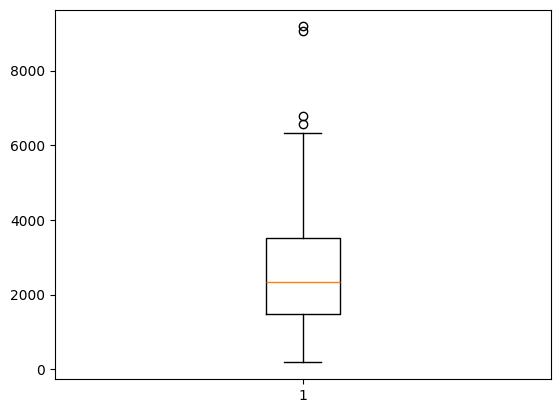

In [123]:
_ = plt.boxplot(df_documents['num_tokens'], showfliers=True)
plt.savefig(f'{my_git_root}/notebooks/images/boxplot_original_tokens.svg')

# Chunking documents

## Step 1: Split Documents based on the detected headings

In [124]:
# Split the documents whenever one or more headings symbols # are detected
# Store the number of splits per document
names = []
documents_split = []

for index, row in df_documents.iterrows():
    document_split = re.split(r'\s*#+\s*', row['text'])
    names.append([row['name']] * len(document_split))
    documents_split.append(document_split)

# Flatten the lists from 2-dimensional to 1-dimensional
names = flatten(names)
documents_split = flatten(documents_split)

In [125]:
# Calculate the number of tokens after splitting
num_tokens = []
for text in documents_split:
    tokens = tokenizer.tokenize(text)
    num_tokens.append(len(tokens))

In [126]:
# Create dataframe
df_documents_split = pd.DataFrame(data={
    'name': names,
    'text': documents_split,
    'num_tokens': num_tokens
})

In [127]:
# Remove chunks without letters
mask = df_documents_split['text'].apply(contains_text)
df_documents_split = df_documents_split[mask].reset_index(drop=True)

In [128]:
# What does our dataset look like now?
df_documents_split.sort_values(by=['num_tokens'], ascending=False)

,name,text,num_tokens
1228,university-medical-center-utrecht.md,4. Abbreviations and definitions\n\n<html><bod...,2018
1827,university-of-strathclyde.md,Appendix A – Glossary of Terms\n\n<html><body>...,1990
179,de-montfort-university.md,SCOPE \n\n3. This policy applies to all DMU s...,1945
1367,university-of-copenhagen.md,Appendix 1: Definitions\n\n<html><body><table>...,1831
74,brunel-university-london.md,Managing research data \n\n1. The University ...,1585
...,...,...,...
1256,university-of-abertay-dundee.md,Responsibilities,1
317,faculty-of-humanities-of-utrecht-university.md,Definitions,1
72,brunel-university-london.md,Policy,1
830,royal-college-of-art.md,Contents,1


In [129]:
fig = px.histogram(df_documents_split, x='num_tokens', nbins=100)
fig.update_layout(height=500, width=1000)
fig.write_image(f'{my_git_root}/notebooks/images/1_token_hist_headings.pdf')

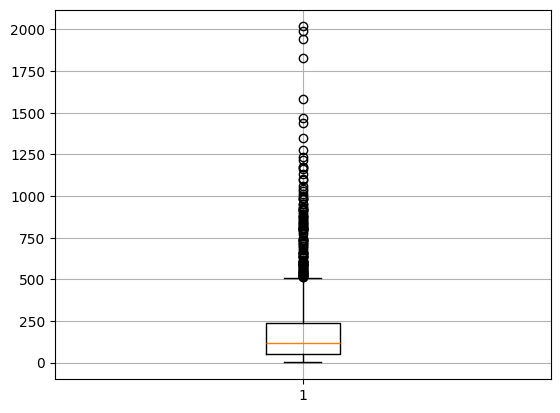

In [130]:
_ = plt.boxplot(df_documents_split['num_tokens'], showfliers=True)
plt.grid()
plt.savefig(f'{my_git_root}/notebooks/images/1_token_boxplot_headings.svg')

**After this point, we ONLY split if the chunks exceed the given sentence_transformer_max_tokens!!**

## Step 2: Split by Section Numbering (First Order)

In [131]:
# Split the documents whenever a numbering '\n1.', '\n2.', '\n3.' is detected right after a linebreak
# We only consider linebreaks of the first order, so we do not consider '\n1.1.', '\n1.2.', '\n1.3.'
# Store the number of splits per document
names = []
documents_split = []

for index, row in df_documents_split.iterrows():
    if row['num_tokens'] > sentence_transformer_max_tokens:
        document_split = re.split(r'\n\d+\.\s*(?!\d+\.?)\s*', row['text'])
        names.append([row['name']] * len(document_split))
    else:
        document_split = row['text']
        names.append(row['name'])
    documents_split.append(document_split)

# Flatten the lists from 2-dimensional to 1-dimensional
names = flatten(names)
documents_split = flatten(documents_split)

In [132]:
# Calculate the number of tokens after splitting
num_tokens = []
for text in documents_split:
    tokens = tokenizer.tokenize(text)
    num_tokens.append(len(tokens))

In [133]:
# Create dataframe
df_documents_split = pd.DataFrame(data={
    'name': names,
    'text': documents_split,
    'num_tokens': num_tokens
})

In [134]:
# Remove chunks without letters
mask = df_documents_split['text'].apply(contains_text)
df_documents_split = df_documents_split[mask].reset_index(drop=True)

In [135]:
# What does our dataset look like now?
df_documents_split.sort_values(by=['num_tokens'], ascending=False)

,name,text,num_tokens
1406,university-medical-center-utrecht.md,4. Abbreviations and definitions\n\n<html><bod...,2018
2093,university-of-strathclyde.md,Appendix A – Glossary of Terms\n\n<html><body>...,1990
1562,university-of-copenhagen.md,Appendix 1: Definitions\n\n<html><body><table>...,1831
954,robert-gordon-university.md,5. Roles and Responsibilities\n\nIt is the col...,1469
2060,university-of-salford.md,7.0 Contact\n\na. Queries regarding research d...,1348
...,...,...,...
1052,technical-university-delft.md,Introduction,1
1008,staffordshire-university.md,Policy\n,1
1075,technical-university-of-darmstadt.md,Guidelines\n,1
1708,university-of-helsinki.md,Contents,1


In [136]:
fig = px.histogram(df_documents_split, x='num_tokens', nbins=100)
fig.update_layout(height=500, width=1000)
fig.write_image(f'{my_git_root}/notebooks/images/2_token_hist_sections_1.pdf')

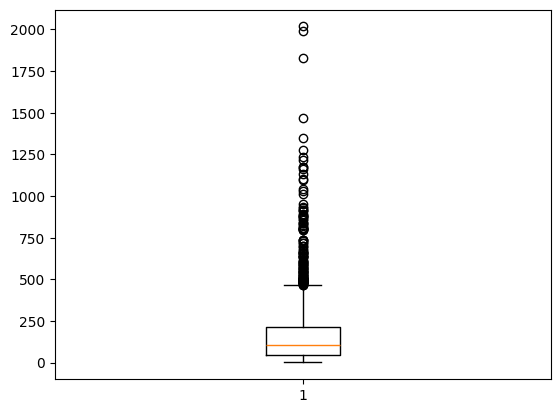

In [137]:
_ = plt.boxplot(df_documents_split['num_tokens'], showfliers=True)
plt.savefig(f'{my_git_root}/notebooks/images/2_token_boxplot_sections_1.svg')

## Step 3: Split by Section Numbering (Second Order)

In [138]:
# Split the documents whenever a second-order numbering '\n1.1', '\n2.1.', '\n3.4' is detected right after a linebreak
# Store the number of splits per document

names = []
documents_split = []

for index, row in df_documents_split.iterrows():
    if row['num_tokens'] > sentence_transformer_max_tokens:
        document_split = re.split(r'\n(?<!\d\.)\d+\.\s*\d+\.?\s+', row['text'])
        names.append([row['name']] * len(document_split))
    else:
        document_split = row['text']
        names.append(row['name'])
    documents_split.append(document_split)

# Flatten the lists from 2-dimensional to 1-dimensional
names = flatten(names)
documents_split = flatten(documents_split)

In [139]:
# Calculate the number of tokens after splitting
num_tokens = []
for text in documents_split:
    tokens = tokenizer.tokenize(text)
    num_tokens.append(len(tokens))

In [140]:
# Create dataframe
df_documents_split = pd.DataFrame(data={
    'name': names,
    'text': documents_split,
    'num_tokens': num_tokens
})

In [141]:
# Remove chunks without letters
mask = df_documents_split['text'].apply(contains_text)
df_documents_split = df_documents_split[mask].reset_index(drop=True)

In [142]:
# What does our dataset look like now?
df_documents_split.sort_values(by=['num_tokens'], ascending=False)

,name,text,num_tokens
1480,university-medical-center-utrecht.md,4. Abbreviations and definitions\n\n<html><bod...,2018
2240,university-of-strathclyde.md,Appendix A – Glossary of Terms\n\n<html><body>...,1990
1646,university-of-copenhagen.md,Appendix 1: Definitions\n\n<html><body><table>...,1831
1006,robert-gordon-university.md,5. Roles and Responsibilities\n\nIt is the col...,1469
2192,university-of-salford.md,7.0 Contact\n\na. Queries regarding research d...,1348
...,...,...,...
1909,university-of-hull.md,Introduction,1
1922,university-of-hull.md,Responsibilities,1
1915,university-of-hull.md,Principles,1
788,max-delbrück-center-for-molecular-medicine.md,Content,1


In [143]:
fig = px.histogram(df_documents_split, x='num_tokens', nbins=100)
fig.update_layout(height=500, width=1000)
fig.write_image(f'{my_git_root}/notebooks/images/3_token_hist_sections_2.pdf')

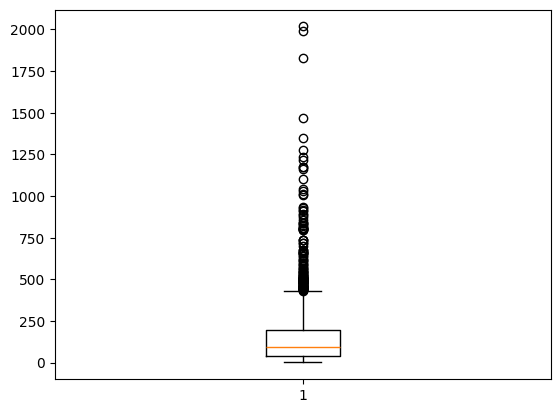

In [144]:
_ = plt.boxplot(df_documents_split['num_tokens'], showfliers=True)
plt.savefig(f'{my_git_root}/notebooks/images/3_token_boxplot_sections_2.svg')

## Step 4: Split by paragraphs

In [145]:
# Split the documents by paragraphs '\n\n'
# Store the number of splits per document
names = []
documents_split = []

for index, row in df_documents_split.iterrows():
    if row['num_tokens'] > sentence_transformer_max_tokens:
        document_split = re.split(r'\s*\n\s*\n\s*', row['text'])
        names.append([row['name']] * len(document_split))
    else:
        document_split = row['text']
        names.append(row['name'])
    documents_split.append(document_split)

# Flatten the lists from 2-dimensional to 1-dimensional
names = flatten(names)
documents_split = flatten(documents_split)

In [146]:
# Calculate the number of tokens
num_tokens = []
for text in documents_split:
    tokens = tokenizer.tokenize(text)
    num_tokens.append(len(tokens))

In [147]:
# Create dataframe
df_documents_split = pd.DataFrame(data={
    'name': names,
    'text': documents_split,
    'num_tokens': num_tokens
})

In [148]:
# Remove chunks without letters
mask = df_documents_split['text'].apply(contains_text)
df_documents_split = df_documents_split[mask].reset_index(drop=True)

In [149]:
# What does our dataset look like now?
df_documents_split.sort_values(by=['num_tokens'], ascending=False)

,name,text,num_tokens
2698,university-of-salford.md,"<html><body><table><tr><td colspan=""4"">niversi...",1295
1835,university-medical-center-utrecht.md,<html><body><table><tr><td>Human research</td>...,1031
1285,robert-gordon-university.md,<html><body><table><tr><td></td><td>Institutio...,863
1834,university-medical-center-utrecht.md,<html><body><table><tr><td>Term</td><td>Defini...,857
533,free-university-berlin.md,‘§ 43 Mitglieder der Hochschule’. 2011. Gesetz...,819
...,...,...,...
1873,university-of-abertay-dundee.md,Responsibilities,1
1009,medizinische-universität-graz.md,MU,1
762,iscte---instituto-universitario-de-lisboa.md,Introduction,1
989,max-delbrück-center-for-molecular-medicine.md,Content,1


In [150]:
fig = px.histogram(df_documents_split, x='num_tokens', nbins=100)
fig.update_layout(height=500, width=1000)
fig.write_image(f'{my_git_root}/notebooks/images/4_token_hist_paragraphs.pdf')

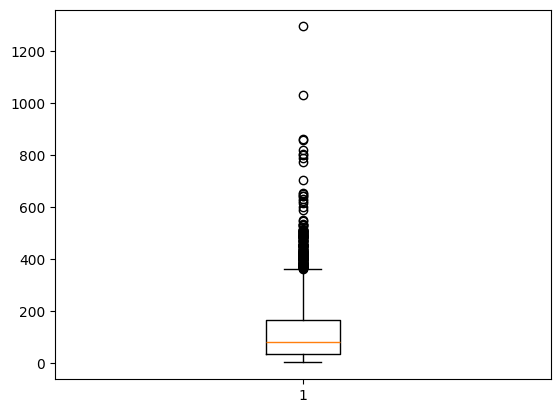

In [151]:
_ = plt.boxplot(df_documents_split['num_tokens'], showfliers=True)
plt.savefig(f'{my_git_root}/notebooks/images/4_token_boxplot_paragraphs.svg')

## Step 5: Extract table data

In [152]:
# Extract the data from the table into plain text
documents_split = df_documents_split['text'].apply(extract_table).to_list()
df_documents_split['text'] = documents_split

In [153]:
# Calculate the number of tokens
num_tokens = []
for text in documents_split:
    tokens = tokenizer.tokenize(text)
    num_tokens.append(len(tokens))

In [154]:
# Add to dataframe
df_documents_split['num_tokens'] = num_tokens

In [155]:
#What does our data look like now?
df_documents_split.sort_values(by=['num_tokens'], ascending=False)

,name,text,num_tokens
533,free-university-berlin.md,‘§ 43 Mitglieder der Hochschule’. 2011. Gesetz...,819
112,brunel-university-london.md,data management: researchdata@brunel.ac.uk See...,652
1835,university-medical-center-utrecht.md,Human researchAllscientificresearchinwhichpeop...,616
1285,robert-gordon-university.md,InstitutionSchoolAcademicGuidanceDocumentation...,588
747,international-institute-for-geo---information-...,All research activities involving personal dat...,534
...,...,...,...
2648,university-of-reading.md,Guidance,1
1960,university-of-cambridge.md,Background\n,1
1270,robert-gordon-university.md,Infrastructure,1
1287,royal-college-of-art.md,Contents,1


In [156]:
fig = px.histogram(df_documents_split, x='num_tokens', nbins=100)
fig.update_layout(height=500, width=1000)
fig.write_image(f'{my_git_root}/notebooks/images//5_token_hist_tables.pdf')

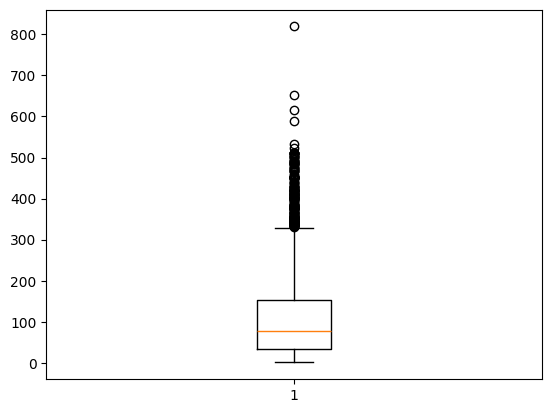

In [157]:
_ = plt.boxplot(df_documents_split['num_tokens'], showfliers=True)
plt.savefig(f'{my_git_root}/notebooks/images/5_token_boxplot_tables.svg')

## Step 6: Split newlines

In [158]:
# If any chunk is still too long, we split it by its newline symbols '\n'
# Split the documents by list items while keeping track of the names
names = []
documents_split = []

for index, row in df_documents_split.iterrows():
    if row['num_tokens'] > sentence_transformer_max_tokens:
        document_split = re.split(r'\n+', row['text'])
        names.append([row['name']] * len(document_split))
    else:
        document_split = row['text']
        names.append(row['name'])
    documents_split.append(document_split)

# Flatten the lists from 2-dimensional to 1-dimensional

names = flatten(names)
documents_split = flatten(documents_split)

In [159]:
# Calculate the number of tokens

num_tokens = []
for text in documents_split:
    tokens = tokenizer.tokenize(text)
    num_tokens.append(len(tokens))

In [160]:
# Create dataframe
df_documents_split = pd.DataFrame(data={
    'name': names,
    'text': documents_split,
    'num_tokens': num_tokens
})

In [161]:
# What does our data look like now?
df_documents_split.sort_values(by=['num_tokens'], ascending=False)

,name,text,num_tokens
112,brunel-university-london.md,data management: researchdata@brunel.ac.uk See...,652
1870,university-medical-center-utrecht.md,Human researchAllscientificresearchinwhichpeop...,616
1312,robert-gordon-university.md,InstitutionSchoolAcademicGuidanceDocumentation...,588
1869,university-medical-center-utrecht.md,TermDefinitieAnonymiseThe removal of directly ...,512
1639,the-university-of-northampton.md,4.2 Research data management procedure\n\nAt t...,512
...,...,...,...
1908,university-of-abertay-dundee.md,Responsibilities,1
53,aston-university.md,Appendix,1
2608,university-of-potsdam.md,Contents,1
484,faculty-of-humanities-of-utrecht-university.md,Regulations,1


In [162]:
fig = px.histogram(df_documents_split, x='num_tokens', nbins=100)
fig.update_layout(height=500, width=1000)
fig.write_image(f'{my_git_root}/notebooks/images/6_token_hist_newlines.pdf')

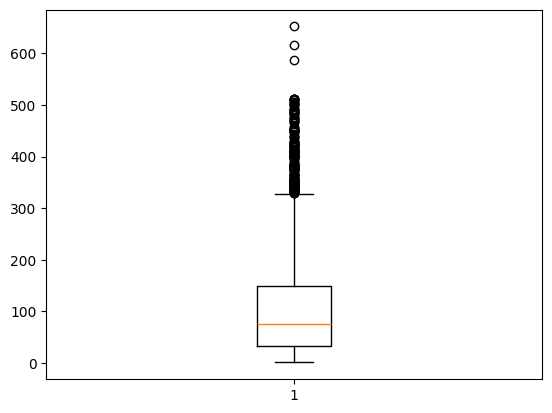

In [163]:
_ = plt.boxplot(df_documents_split['num_tokens'], showfliers=True)
plt.savefig(f'{my_git_root}/notebooks/images/6_token_boxplot_newlines.svg')


## Step 7: Split chunks into halves

In [164]:
# For all the remaining chunks, we will simply cut them in half
# Split the documents by paragraphs while keeping track of the names
names = []
documents_split = []

for index, row in df_documents_split.iterrows():
    if row['num_tokens'] > sentence_transformer_max_tokens:
        text = row['text']
        document_split = [text[:len(text)//2], text[len(text)//2:]]
        names.append([row['name']] * 2)
    else:
        document_split = row['text']
        names.append(row['name'])
    documents_split.append(document_split)

# Flatten the lists from 2-dimensional to 1-dimensional

names = flatten(names)
documents_split = flatten(documents_split)

In [165]:
# Calculate the number of tokens

num_tokens = []
for text in documents_split:
    tokens = tokenizer.tokenize(text)
    num_tokens.append(len(tokens))

In [166]:
# Create dataframe
df_documents_split = pd.DataFrame(data={
    'name': names,
    'text': documents_split,
    'num_tokens': num_tokens
})

In [167]:
# Remove chunks without letters
mask = df_documents_split['text'].apply(contains_text)
df_documents_split = df_documents_split[mask].reset_index(drop=True)

In [168]:
# What does our data look like now?
df_documents_split.sort_values(by=['num_tokens'], ascending=False)

,name,text,num_tokens
1871,university-medical-center-utrecht.md,TermDefinitieAnonymiseThe removal of directly ...,512
1641,the-university-of-northampton.md,4.2 Research data management procedure\n\nAt t...,512
2404,university-of-hull.md,Managing data\n\nThe management of research da...,511
933,leiden-university.md,B. Responsibilities \n\n10. The Faculty Board...,511
319,de-montfort-university.md,DEFINITIONS \n\n“The University” and “DMU” me...,511
...,...,...,...
1998,university-of-cambridge.md,Background\n,1
477,faculty-of-humanities-of-utrecht-university.md,Definitions,1
102,brunel-university-london.md,Policy,1
287,de-montfort-university.md,SCOPE \n,1


In [169]:
fig = px.histogram(df_documents_split, x='num_tokens', nbins=100)
fig.update_layout(height=500, width=1000)
fig.write_image(f'{my_git_root}/notebooks/images/7_token_hist_halves.pdf')

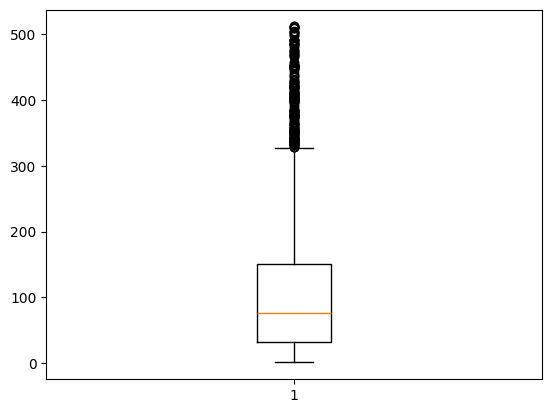

In [170]:
_ = plt.boxplot(df_documents_split['num_tokens'], showfliers=True)
plt.savefig(f'{my_git_root}/notebooks/images/7_token_boxplot_halves.svg')

# Export chunked dataset

In [171]:
# df_documents_split.to_csv(f'{my_git_root}/data/documents_chunked.csv', index=False)